In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue
import seaborn as sns
sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Libraries Imported')
print('Cuda Device Found? ', torch.cuda.is_available())

if torch.cuda.is_available == True:
    print('Type of Cuda Device:', torch.cuda.get_device_name(device))

Libraries Imported
Cuda Device Found?  True


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [2]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

one_hot_classes = F.one_hot(train_classes, num_classes = 10).float()

The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


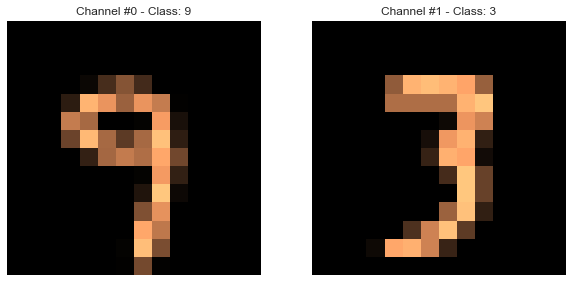

In [3]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Put the data tensors to the CUDA device (if found).

In [4]:
train_set, test_set = train_set.to(device), test_set.to(device)
train_target, test_target = train_target.to(device), test_target.to(device)
train_classes, test_classes = train_classes.to(device), test_classes.to(device)
one_hot_classes = one_hot_classes.to(device)

print('Train Set in cuda device?', train_set.is_cuda)

Train Set in cuda device? True


##### Train Function

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer with Cosine Annealing with Warm Restarts as its scheduler.

Calculation of the auxiliary loss using target classes is enabled by default and if someone wants no auxiliary loss, setting *gamma* $\gamma = 0$ does the job.

Number of epochs $e$, learning rate $\eta$, auxiliary loss multiplier $\gamma$, main loss criterion $l$, and batch size $b$ are taken as hyper-parameters.

In [5]:
def train_model(n_epochs, eta, gamma, loss_criterion, model, train_input, train_target, train_classes, mini_batch_size):
    aux_loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr = eta)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5, T_mult = 1, eta_min = 0.0001)
    losses = []
    for _ in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
                        
            ### Setting the gradients to zero before the loss calculation
            model.zero_grad()
            ### Train function expects a model with two outputs otherwise it will not work
            output, output_aux = model(train_input.narrow(0, b, mini_batch_size))
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            main_loss = loss_criterion(output, train_target.narrow(0, b, mini_batch_size).float())
            # print('Aux Shapes: ', output_aux.shape, train_classes.narrow(0, b, mini_batch_size).shape)
            # print('Reshaped and Softmax', F.softmax(output_aux.view(mini_batch_size, 2, 10), dim = 2))
            
            ### Outputs needed to go in the auxiliary loss calculation are reshaped to the (n_batches x images channels x number of classes) dimension
            ### After reshaping, a softmax function is applied to convert them to probabilities needing to be compared with 10 one-hot-encoded targets
            aux_loss = aux_loss_criterion(F.softmax(output_aux.view(mini_batch_size, 2, 10), dim = 2), train_classes.narrow(0, b, mini_batch_size))
            
            ### Total loss calculated as a function of the main loss and auxiliary loss
            loss = main_loss + (gamma * aux_loss)
            
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    
    ## Needed if you want to plot the loss over epochs
    all_epochs = [i + 1 for i in range(n_epochs)]    
    
    # plt.figure()
    # plt.plot(all_epochs, losses, linewidth = 3, color = 'turquoise')
    # plt.title('Aux Loss over epochs (Cosine Annealing LR Scheduler)')
    # plt.xlabel('Number of Epochs')
    # plt.ylabel('Loss')
    # plt.show()
    
    # print('Final Output: ', output, output.shape)
    # print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

##### Error Function

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

The sigmoid function $\sigma(x) = \frac 1 {1+exp(-x)}$ is applied to the output to distribute the output values between $0$ and $1$, after which a rounding process happens to finally compare them with our binary targets. 

In [6]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    with torch.no_grad():
        for b in range(0, input.size(0), mini_batch_size):
            
            ### When we apply sigmoid inside the model
            # output = model(input.narrow(0, b, mini_batch_size))
            output, _ = model(input.narrow(0, b, mini_batch_size))
            output_sigmoid = torch.sigmoid(output)
            # print('final output', output)
            errors = torch.where(torch.round(output_sigmoid) != target.narrow(0, b, mini_batch_size))

            ## Errors return a tuple with the first element being a tensor with indexes
            ## Where the targets and predictions dont match
            ## Therefore we get the size of this tensor as a number of errors
            nb_errors += errors[0].size(0) 
    return nb_errors

##### Defining models
Cell that imports all models discussed in the report, MLP, LegacyCNN, CNN + Weight Sharing. 

Specifically, a classical Binary Convolutional Network Classifier inspired by LeNet, with convolutional layers as feature extractors and fully connected layers as classifiers, and a 
a Multi-Layer Perceptron with only linear hidden layers, constructed in order to compare the difference between this and the convolutional network, measuring the overfitting too. 

All models includes dropout layers with respective rates of $p_D$ set as a parameter and share a weight decay parameter on the Adam Optimizer, as measures to combat overfitting. CNN models have the dropout layer before the final output layer while the MLP model has a dropout layer after each FC layer.

All models have auxiliary loss using the target classes implemented, with the $\gamma$ hyper-parameter defining the effect of it. If you don't want auxiliary loss, set $\gamma = 0$ when calling the train function.

Check the corresponding *.py* files to inspect the full models.

In [7]:
from models.MLP_model import MLP
from models.CNN_first_model import BinaryCNNLegacy
from models.CNN_model_aux import BinaryCNNAux
from models.CNN_weight_sharing_model import BinaryCNNSharing

print('models imported')

models imported


Training cell for one model, to be easily switched between MLP and CNN. 

Hyperparameters after benchmarking (average over 10 runs): $40$ - $50$ batch size seems to be the best, $0.01$ or $0.001$ weight decay, $10-25$ epochs sufficient.

As for dropout probability $p_D$, in CNN models values in $\in [0, 0.2]$ are suggested however at the moment better performances are computed with no dropout, while in the MLP model values in $\in [0.1, 0.5]$.

In [19]:
### Loss Criterions & One Hot Encoded target classes
binary_criterion = nn.BCEWithLogitsLoss()

### Hyper-Parameters
eta = 0.001  ## LR
mini_batch_size = 50
nb_epochs = 25
n_runs = 10
epochs = [5, 10, 15, 25, 30, 50]
aux_gammas = [1.0, 0.7, 0.6]  ## Aux Loss Multiplier
dropout_rates = [0.1, 0.2, 0.3, 0.4]

for d in dropout_rates:
    for e in epochs:
        avg_error_train = []
        avg_error_test = []
        for i in range(n_runs):
            # model = MLP(dropout_rate = 0.4)
            # model = BinaryCNNLegacy(dropout_rate = 0.2)      
            # model = BinaryCNNAux(dropout_rate = 0.2)  
            model = BinaryCNNSharing(dropout_rate = d)

            model.to(device) ### Putting model to cuda device or cpu is there is no cuda device
            train_model(e, eta, 1.0, binary_criterion, model, train_set, train_target, one_hot_classes, mini_batch_size)
            
            model.eval()    
            error_train = compute_nb_errors(model, train_set, train_target.to(torch.float64), mini_batch_size)
            avg_error_train.append(error_train / train_set.size(0))
            error_test = compute_nb_errors(model, test_set, test_target.to(torch.float64), mini_batch_size)
            avg_error_test.append(error_test / train_set.size(0))

        print('Classification Error on the training set with {} epochs and dropout rate {} - Average: {:.2f}%'.format(e, d, (sum(avg_error_train) / n_runs) * 100))
        print('Classification Error on the testing set with {} epochs and dropout rate {} - Average: {:.2f}%, Minimum: {:.2f}%, SD: {:.2f}'.format(
            e,
            d,
            (sum(avg_error_test) / n_runs) * 100, 
            min(avg_error_test) * 100, 
            torch.std(torch.Tensor(avg_error_test))
            ))           
        print('')

Classification Error on the training set with 5 epochs and dropout rate 0.1 - Average: 0.57%
Classification Error on the testing set with 5 epochs and dropout rate 0.1 - Average: 13.20%, Minimum: 12.00%, SD: 0.01

Classification Error on the training set with 10 epochs and dropout rate 0.1 - Average: 0.01%
Classification Error on the testing set with 10 epochs and dropout rate 0.1 - Average: 13.24%, Minimum: 11.90%, SD: 0.01

Classification Error on the training set with 15 epochs and dropout rate 0.1 - Average: 0.00%
Classification Error on the testing set with 15 epochs and dropout rate 0.1 - Average: 13.92%, Minimum: 13.20%, SD: 0.01

Classification Error on the training set with 25 epochs and dropout rate 0.1 - Average: 0.00%
Classification Error on the testing set with 25 epochs and dropout rate 0.1 - Average: 13.91%, Minimum: 12.40%, SD: 0.01

Classification Error on the training set with 30 epochs and dropout rate 0.1 - Average: 0.00%
Classification Error on the testing set with

Training cell for both models to calculate their performance on the testing set and to be used for benchmarking & fine-tuning with different hyperparameters.

In [11]:
### Shared parameters to both models
binary_criterion = nn.BCEWithLogitsLoss()
mini_batch_size = 50
n_runs = 10
eta = 0.001
aux_gamma = 0.0

### Lists for Plotting & Benchmarks Purposes
# all_epochs = [i + 1 for i in range(50)]
all_epochs = [1] + [i for i in range(5, 80 + 1, 5)]
all_errors_cnn_train = []
all_errors_mlp_train = []
all_errors_cnn = []
all_errors_mlp = []
test_sd_cnn = []
test_sd_mlp = []
test_max_cnn = []
test_max_mlp = []
test_min_cnn = []
test_min_mlp = []


for e in range(len(all_epochs)):
    avg_error_train_cnn = []
    avg_error_test_cnn = []
    avg_error_train_mlp = []
    avg_error_test_mlp = []
    print('Average over {} Epochs'.format(all_epochs[e]))
    for i in range(n_runs):   
        conv_model = BinaryCNNSharing(dropout_rate = 0.0)
        mlp_model = BinaryCNNSharing(dropout_rate = 0.0)
        
        ## Training CNN - 1.0 Gamma for full auxiliary loss
        conv_model.to(device)
        train_model(all_epochs[e], eta, 1.0, binary_criterion, conv_model, train_set, train_target, one_hot_classes, mini_batch_size)
        
        ## Training MLP - 0.0 Gamma for no auxiliary loss
        mlp_model.to(device)
        train_model(all_epochs[e], eta, 0.0, binary_criterion, mlp_model, train_set, train_target, one_hot_classes, mini_batch_size)
            
        conv_model.eval()
        conv_errors_train = compute_nb_errors(conv_model, train_set, train_target.to(torch.float64), mini_batch_size)
        conv_errors_test = compute_nb_errors(conv_model, test_set, test_target.to(torch.float64), mini_batch_size)
        avg_error_train_cnn.append(conv_errors_train / train_set.size(0))
        avg_error_test_cnn.append(conv_errors_test / test_set.size(0))
        
        mlp_model.eval()
        mlp_errors_train = compute_nb_errors(mlp_model, train_set, train_target.to(torch.float64), mini_batch_size)
        mlp_errors_test = compute_nb_errors(mlp_model, test_set, test_target.to(torch.float64), mini_batch_size)
        avg_error_train_mlp.append(mlp_errors_train / train_set.size(0))
        avg_error_test_mlp.append(mlp_errors_test / test_set.size(0))

    all_errors_cnn_train.append(sum(avg_error_train_cnn) / n_runs)
    all_errors_cnn.append(sum(avg_error_test_cnn) / n_runs)
    test_sd_cnn.append(torch.std(torch.Tensor(avg_error_test_cnn)))
    test_min_cnn.append(min(avg_error_test_cnn))
    test_max_cnn.append(max(avg_error_test_cnn))
    
    all_errors_mlp_train.append(sum(avg_error_train_mlp) / n_runs)
    all_errors_mlp.append(sum(avg_error_test_mlp) / n_runs)
    test_sd_mlp.append(torch.std(torch.Tensor(avg_error_test_mlp)))
    test_min_mlp.append(min(avg_error_test_mlp))
    test_max_mlp.append(max(avg_error_test_mlp))


    print('WSharingCNN - Train Error: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_mlp_train[e] * 100), (min(avg_error_train_mlp) * 100)))
    print('WSharingCNN - Test Error: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_mlp[e] * 100), (min(avg_error_test_mlp) * 100)))
    print('WSharingCNN + Auxiliary Loss - Train Error: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_cnn_train[e] * 100), (min(avg_error_train_cnn) * 100)))
    print('WSharingCNN + Auxiliary Loss - Test Error: Average: {:.2f}%, Minimum: {:.2f}%\n'.format((all_errors_cnn[e] * 100), (min(avg_error_test_cnn) * 100)))

Average over 1 Epochs
WSharingCNN - Train Classification Error: Average: 14.06%, Minimum: 12.70%
WSharingCNN - Test Classification Error: Average: 17.37%, Minimum: 15.90%
WSharingCNN + Auxiliary Loss - Train Classification Error: Average: 14.31%, Minimum: 12.60%
WSharingCNN + Auxiliary Loss - Test Classification Error: Average: 17.50%, Minimum: 15.90%

Average over 5 Epochs
WSharingCNN - Train Classification Error: Average: 0.60%, Minimum: 0.10%
WSharingCNN - Test Classification Error: Average: 13.23%, Minimum: 12.30%
WSharingCNN + Auxiliary Loss - Train Classification Error: Average: 0.51%, Minimum: 0.20%
WSharingCNN + Auxiliary Loss - Test Classification Error: Average: 13.32%, Minimum: 12.40%

Average over 10 Epochs
WSharingCNN - Train Classification Error: Average: 0.01%, Minimum: 0.00%
WSharingCNN - Test Classification Error: Average: 12.96%, Minimum: 12.10%
WSharingCNN + Auxiliary Loss - Train Classification Error: Average: 0.00%, Minimum: 0.00%
WSharingCNN + Auxiliary Loss - Tes

As we can view from the plot below, the overfitting on the testing set persists no matter the number of epochs.

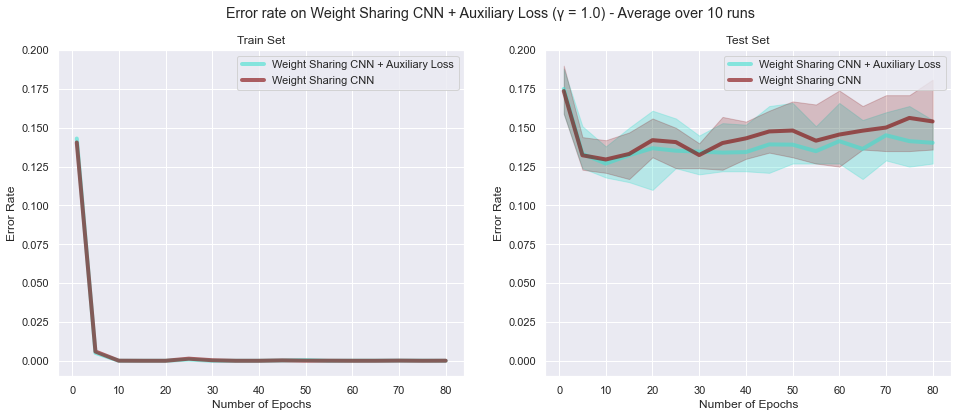

In [15]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Error rate on Weight Sharing CNN + Auxiliary Loss (\u03B3 = 1.0) - Average over 10 runs')
axs[0].set_title("Train Set")
axs[0].plot(all_epochs, all_errors_cnn_train, alpha=0.6, linewidth=4, color='turquoise', label='Weight Sharing CNN + Auxiliary Loss')
axs[0].plot(all_epochs, all_errors_mlp_train, alpha=0.6, linewidth=4, color='maroon', label='Weight Sharing CNN')
axs[0].legend(loc='upper right')

axs[1].set
axs[1].set_title("Test Set")
axs[1].plot(all_epochs, all_errors_cnn, alpha=0.6, linewidth=4, color='turquoise', label='Weight Sharing CNN + Auxiliary Loss')
axs[1].plot(all_epochs, all_errors_mlp, alpha=0.6, linewidth=4, color='maroon', label='Weight Sharing CNN')
axs[1].fill_between(all_epochs, test_max_cnn, test_min_cnn, color='turquoise', alpha = 0.3)
axs[1].fill_between(all_epochs, test_max_mlp, test_min_mlp, color='maroon', alpha = 0.2)
axs[1].legend(loc='upper right')

for ax in axs.flat:
    ax.set(xlabel='Number of Epochs', ylabel='Error Rate', ylim=(-0.01, 0.2))
plt.show()